In [2]:
from google.cloud import storage
import os
import netCDF4
import numpy as np
import numpy.ma as ma
from dask import delayed
import dask.array as da
from dask.distributed import Client
import glob
import tempfile
import subprocess
import datetime, time
from urllib import request
from multiprocessing import Pool
import json
import gc
import boto3
import botocore
import itertools

storage_client = storage.Client.from_service_account_json('/home/jovyan/work/credentials.json')
bucket = storage_client.get_bucket('nex-gddp')

loca_bucket = 'nasanex'
base_key_path = 'LOCA'
base_url = 'ftp://gdo-dcp.ucllnl.org/pub/dcp/archive/cmip5/loca/LOCA_2016-04-02/'
all_models = ["ACCESS1-0","ACCESS1-3","CCSM4","CESM1-BGC","CESM1-CAM5","CMCC-CM","CMCC-CMS","CNRM-CM5","CSIRO-Mk3-6-0","CanESM2","EC-EARTH","FGOALS-g2","GFDL-CM3","GFDL-ESM2G","GFDL-ESM2M","GISS-E2-H","GISS-E2-R","HadGEM2-AO","HadGEM2-CC","HadGEM2-ES","IPSL-CM5A-LR","IPSL-CM5A-MR","MIROC-ESM","MIROC-ESM-CHEM","MIROC5","MPI-ESM-LR","MPI-ESM-MR","MRI-CGCM3","NorESM1-M","bcc-csm1-1","bcc-csm1-1-m","inmcm4"]
some_models = ["ACCESS1-0","ACCESS1-3","CCSM4"]

client = Client('scheduler:8786')

s3 = boto3.resource('s3')


# Begin here
def process_model_year(model, scenario, year):
    process_year_temps(model, scenario, year)

def process_year_temps(model, scenario, year):
    print(f"Processing temperatures for {model} {year} ({scenario})")
    ids = (gen_netcdf_id(model, scenario, year, 'tasmax'), gen_netcdf_id(model, scenario, year, 'tasmin'))
    print(f"File ids are: {ids}")
    tasmax_file, tasmin_file = list(map(download_file, ids))
    tasmax_dataset, tasmin_dataset = netCDF4.Dataset(tasmax_file), netCDF4.Dataset(tasmin_file)
    print(tasmax_file)
    print(tasmax_dataset)
    print(tasmax_dataset['tasmax'])
    print(tasmax_dataset['tasmax'].shape)
    pass

def gen_netcdf_id(model, scenario, year, var):
    id = f'LOCA/{model}/16th/{scenario}/r1i1p1/{var}/{var}_day_{model}_{scenario}_r1i1p1_{str(year)}0101-{str(year)}1231.LOCA_2016-04-02.16th.nc'
    return id

def download_file(file_id, loca_bucket = loca_bucket, download_location = '/temp'):
    filename = f'{download_location}/{file_id.split("/")[-1]}'
    print(f"Downloading {filename}")
    try:
        s3.Bucket(loca_bucket).download_file(file_id, filename)
    except botocore.exceptions.ClientError as e:
        if e.response['Error']['Code'] == "404":
            file_id = file_id.replace('r1i1p1', 'r6i1p1')
            s3.Bucket(loca_bucket).download_file(file_id, filename)
    except:
        filename = None
    return filename

def cleanup():
    for file in glob.glob('/temp/*'):
        os.remove(file)

# Actual processing
def hdd(a, axis):
    a_to_baseline = 291.483 - a
    masked = ma.masked_where(a_to_baseline <= 0, a_to_baseline)
    intermediate_matrix = ma.filled(masked, fill_value = 0)
    result = np.sum(intermediate_matrix, axis = 0)
    return result

## BASELINE

# Average of models per year
def process_baseline_year_tasmax(year, models = all_models, file_prefix = ""):
    print("Generating ids")
    ids = [gen_netcdf_id(model, 'historical', year, 'tasmax') for model in models]
    print("Downloading files")
    pool = Pool()
    filenames = pool.map(download_file, ids)
    # shape = (365, 490, 960)
    print("Stacking files")
    arr_list = list(map(lambda fn: da.from_array(netCDF4.Dataset(fn)['tasmax'], chunks = (366, 245, 240)), filenames))
    arr_stack = da.stack(arr_list)
    print("Calculating average")
    year_avg = np.mean(arr_stack, axis = 0).compute()
    result_filename = f"/temp/{file_prefix}_{year}_tasmax_baseline_average.npy"
    np.save(result_filename, year_avg)
    blob = bucket.blob(f'baseline/tasmax/intermediate/{result_filename.split("/")[-1]}')
    blob.upload_from_filename(result_filename)
    print(result_filename)
    return None

def process_baseline_year_pr(year, models = all_models, file_prefix = ""):
    print("Generating ids")
    ids = [gen_netcdf_id(model, 'historical', year, 'pr') for model in models]
    print("Downloading files")
    pool = Pool()
    filenames = pool.map(download_file, ids)
    # shape = (365, 490, 960)
    print("Stacking files")
    arr_list = list(map(lambda fn: da.from_array(netCDF4.Dataset(fn)['pr'], chunks = (366, 245, 240)), filenames))
    arr_stack = da.stack(arr_list)
    print("Calculating average")
    year_avg = np.mean(arr_stack, axis = 0).compute()
    result_filename = f"/temp/{file_prefix}_{year}_pr_baseline_average.npy"
    np.save(result_filename, year_avg)
    blob = bucket.blob(f'baseline/pr/intermediate/{result_filename.split("/")[-1]}')
    blob.upload_from_filename(result_filename)
    print(result_filename)
    return None


In [3]:
client.restart()

Client Scheduler: tcp://scheduler:8786 Dashboard: http://scheduler:8787,Cluster Workers: 1 Cores: 8 Memory: 33.68 GB


In [ ]:
for year in range(1986, 2001):
    cleanup()
    process_baseline_year_pr(year, models = all_models, file_prefix = 'baseline_v1')
process_baseline_year_pr(1985, models = all_models, file_prefix = 'baseline_v1')

In [5]:
lat_stepsize = int(490 / 5)
lon_stepsize = int(960 / 5)
lat_range = list(range(0, 490, lat_stepsize))
lon_range = list(range(0, 960, lon_stepsize))

lat_slices = [slice(i, i + lat_stepsize) for i in lat_range]
lon_slices = [slice(i, i + lon_stepsize) for i in lon_range]

all_slices = list(map(lambda tup: (slice(None), *tup), itertools.product(lat_slices, lon_slices)))
len(all_slices)

25

In [ ]:
np.save('baseline_loca_tasmax.npy', final_tasmax_result)

In [ ]:
# Baselines
def load_year_avg(year, sl, var):
    first_arr = np.load(f'/temp/baseline_v1_{str(year)}_{var}_baseline_average.npy')
    second_arr = np.array(first_arr[sl], copy=True)
    del first_arr
    if second_arr.shape[0] == 366:
        second_arr = np.delete(second_arr, 59, axis = 0)
    #print(arr.shape)
    return second_arr

In [14]:
# Tasmax baseline
final_result = []
for raster_slice in all_slices:
    arr_list = list(map(lambda year: load_year_avg(year, raster_slice, 'tasmax'), range(1971, 2001)))
    per_day_mean = np.mean(np.stack(arr_list), axis = 0)
    del arr_list
    final_result.append(np.array(per_day_mean, copy = True))
    del per_day_mean

In [20]:
# PR baseline
final_result_pr = []
for raster_slice in all_slices:
    arr_list = list(map(lambda year: load_year_avg(year, raster_slice, 'pr'), range(1971, 2001)))
    per_day_mean = np.mean(np.stack(arr_list), axis = 0)
    del arr_list
    final_result_pr.append(np.array(per_day_mean, copy = True))
    del per_day_mean

In [21]:
# tasmax
final_stack = np.concatenate([np.concatenate(final_result[i:i+5], axis = -1) for i in range(0, 25, 5)], axis = 1)
final_stack[final_stack > 500] = 0
# pr
final_stack_pr = np.concatenate([np.concatenate(final_result_pr[i:i+5], axis = -1) for i in range(0, 25, 5)], axis = 1)
final_stack_pr[final_stack_pr > 500] = 0

In [22]:
np.save('loca_baseline_per_day_tasmax.npy', final_stack)
np.save('loca_baseline_per_day_pr.npy', final_stack_pr)

In [23]:
baseline_tasmax = np.load('loca_baseline_per_day_tasmax.npy')
masked_baseline_tasmax = ma.masked_where(baseline_tasmax == 0, baseline_tasmax)
masked_baseline_tasmax

masked_array(data =
 [[[-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  ..., 
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]]

 [[-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  ..., 
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]]

 [[-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  ..., 
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]]

 ..., 
 [[-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  ..., 
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]]

 [[-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  ..., 
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]]

 [[-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  ..., 
  [-- -- -- ..., -- -- 

In [24]:
baseline_pr = np.load('loca_baseline_per_day_pr.npy')
masked_baseline_pr = ma.masked_where(baseline_pr == 0, baseline_pr)
masked_baseline_pr

masked_array(data =
 [[[-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  ..., 
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]]

 [[-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  ..., 
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]]

 [[-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  ..., 
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]]

 ..., 
 [[-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  ..., 
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]]

 [[-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  ..., 
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]]

 [[-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  [-- -- -- ..., -- -- --]
  ..., 
  [-- -- -- ..., -- -- 

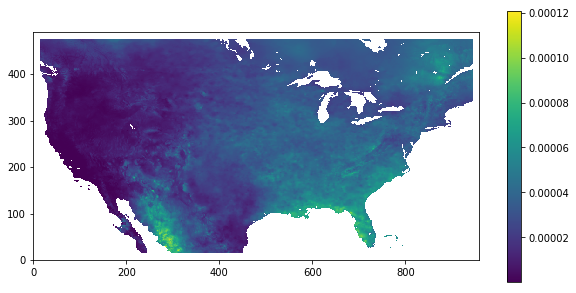

In [27]:
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.imshow(masked_baseline_pr[200, :, :], origin = 'lower')
plt.colorbar()

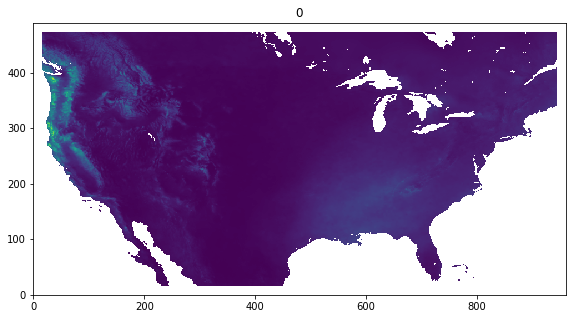

In [28]:
%matplotlib inline
from matplotlib import animation

def animate(nframe):
    #plt.cla()
    plt.imshow(masked_baseline_pr[nframe, :, :], origin = 'lower')
    plt.title(str(nframe))

fig = plt.figure(figsize=(10,5))
anim = animation.FuncAnimation(fig, animate, frames=365)
anim.save('demoanimation_pr.gif', writer='imagemagick', fps=60);
#plt.colorbar()